## Multiclass Classification of Customer Service Queries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stopwords = stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
queries = pd.read_csv('Customer_Service_Questions_Multiclass.csv')
print(queries.shape)
queries.head()

(5000, 2)


,question,topic
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,I'm going to be out of the country for about a...,Shipping
2,I was wondering if you'd be able to overnight ...,Shipping
3,The Swingline electronic stapler (472555) look...,Shipping
4,I think this cosmetic bag would work great for...,Shipping


Product Specifications    839
Product Availability      833
Product Comparison        806
Shipping                  799
Returns & Refunds         768
Sales/Promotions          505
Omnichannel               450
Name: topic, dtype: int64


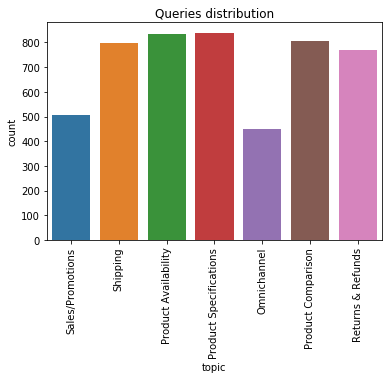

In [3]:
print(queries.topic.value_counts())
sns.countplot(x="topic", data=queries)
plt.xticks(rotation="vertical")
plt.title("Queries distribution")
plt.show()

### Preprocessing

In [4]:
# Remove punctuation, remove stop words, tokenize and lemmatize
lemmatizer = WordNetLemmatizer()
clean_text = []
for i in queries['question']:
    words = regexp_tokenize(i.lower(), r'[A-Za-z]+')
    words = [w for w in words if len(w)>1 and w not in stopwords]
    words = [lemmatizer.lemmatize(w) for w in words]
    clean_text.append(' '.join(words))
queries['text'] = clean_text
queries = queries.drop(['question'],1)

In [5]:
queries.head()

,topic,text
0,Sales/Promotions,hi sign email list select get email exclusivel...
1,Shipping,going country week travel going getting animal...
2,Shipping,wondering able overnight jacket item trenton nj
3,Shipping,swingline electronic stapler look really great...
4,Shipping,think cosmetic bag would work great however kn...


In [6]:
# Split to test and train data
X_train, X_test, y_train, y_test = train_test_split(queries['text'], queries['topic'], 
                                                    test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4000,), (4000,), (1000,), (1000,))

In [7]:
# Vectorizing
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',max_features=5000)
# fit method will train the vectorizer object to learn the words in the corpus
tfidf_vect_fit = tfidf_vect.fit(X_train)
# using the same fit to transform the test and train datasets 
tfidf_train = tfidf_vect_fit.transform(X_train)
tfidf_test = tfidf_vect_fit.transform(X_test)
tfidf_train.shape, tfidf_test.shape

((4000, 4984), (1000, 4984))

In [8]:
# Encoding the label 'topic'
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

queries['id'] =  queries['topic'].factorize()[0]
topics_id_df = queries[['topic', 'id']].drop_duplicates().sort_values('id')
topics_to_id = dict(topics_id_df.values)
id_to_topic = dict(topics_id_df[['id', 'topic']].values)

### Building Models

In [9]:
from sklearn.svm import LinearSVC,SVC
svcModel = LinearSVC().fit(tfidf_train, y_train)
svc_conf_matrix = confusion_matrix(y_test, svcModel.predict(tfidf_test))

In [10]:
from sklearn.ensemble import RandomForestClassifier
#n_estimators = 50, n_jobs = -1, max_depth = 20 
rfModel = RandomForestClassifier(n_estimators = 100,n_jobs= -1)
rfModel.fit(tfidf_train,y_train)
rf_conf_matrix = confusion_matrix(y_test, rfModel.predict(tfidf_test))

In [11]:
from sklearn.linear_model import SGDClassifier
sgdModel = SGDClassifier(loss="hinge",penalty="elasticnet",max_iter=200, tol=1e-3)
sgdModel.fit(tfidf_train, y_train)
sgd_conf_matrix = confusion_matrix(y_test, sgdModel.predict(tfidf_test))

* For the SVM Model I tried chaging the kernel function to poly, rbf and sigmoid, But linear kernel only has the highest accuracy
* Using Random forest grid search model I found that the training and test accuracy was high with hyperparameters max_depth = None and n_estimators as 100
* I've used Stochastic Gradient Descent classifier as the third model. The hyperparameter tuning was done with parameters loss, penalty and maximum interations. The maximum iterations dont seem to have an effect on accuracy but the loss function "hinge" has given maximum accuracy than others.

### Models Evaluation

In [12]:
print('\033[1m'+'SVM Model')
print('\033[0m')
print(classification_report(y_test, svcModel.predict(tfidf_test), \
    target_names=queries['topic'].unique()))
print('\033[1m'+'Random Forest Model')
print('\033[0m')
print(classification_report(y_test, rfModel.predict(tfidf_test), \
    target_names=queries['topic'].unique()))
print('\033[1m'+'Stochastic Gradient Descent Model')
print('\033[0m')
print(classification_report(y_test, sgdModel.predict(tfidf_test), \
    target_names=queries['topic'].unique()))

SVM Model

                        precision    recall  f1-score   support

      Sales/Promotions       1.00      1.00      1.00        92
              Shipping       0.96      0.94      0.95       172
  Product Availability       0.93      0.98      0.95       155
Product Specifications       0.94      0.92      0.93       161
           Omnichannel       0.99      1.00      1.00       170
    Product Comparison       0.98      0.96      0.97        97
     Returns & Refunds       1.00      1.00      1.00       153

              accuracy                           0.97      1000
             macro avg       0.97      0.97      0.97      1000
          weighted avg       0.97      0.97      0.97      1000

Random Forest Model

                        precision    recall  f1-score   support

      Sales/Promotions       1.00      0.98      0.99        92
              Shipping       0.93      0.95      0.94       172
  Product Availability       0.96      0.98      0.97       155
Prod

<b>Metrics for classification</b>
<br>
* Metrics precision, recall and F1-score are used to evaluate a classification problem as these metrics identify how precisely model can classify different categories. 
* Accuracy is not a good metric for classification, model can be wrong though it has high accuracy. Accuracy favours the major class of the classification data. 
* The metrics recall and precision favours the minority class of data which is more useful.

In [13]:
import seaborn as sns
def sns_conf_matrix(conf_matrix,topics_id_df,model):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_ylim([0,2])
    plt.tight_layout()
    plt.title(model + ' ' + 'Confusion Matrix', fontsize=16)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="BuPu",
        xticklabels=topics_id_df[['topic']].values, 
        yticklabels=topics_id_df[['topic']].values, square=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

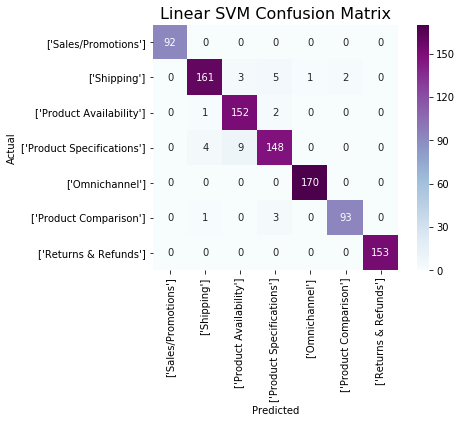

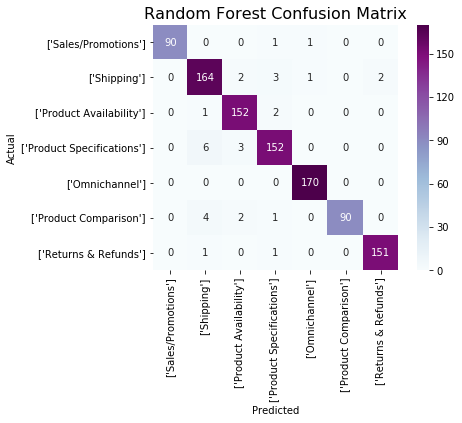

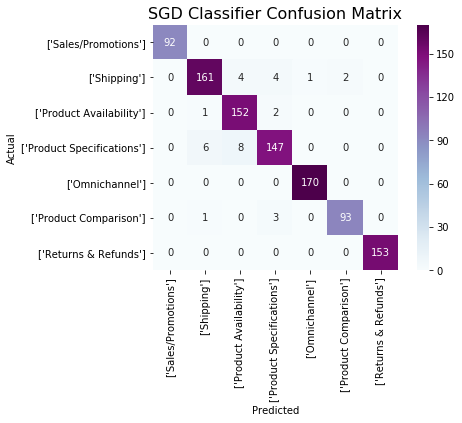

In [14]:
sns_conf_matrix(svc_conf_matrix,topics_id_df,'Linear SVM')
sns_conf_matrix(rf_conf_matrix,topics_id_df,'Random Forest')
sns_conf_matrix(sgd_conf_matrix,topics_id_df,'SGD Classifier')

All the three models were equally efficient in prediction and accuracy. 
<br>
Considering single category topic 'production specifications', 
<br>
* linear SVM model has correctly  predicted product specification 148 times. It incorrectly identified 4 as shipping and and 9 as product availability
* Random Forest classifier has identified 151 queries correctly and rest 8 as shipping and 2 as availability
* SGD classifier has identified 147 queries and remaining 6 as shippping and 8 as product availability

Also considering various other topics shipping, product availability, omnichannel, returns & refunds the random forest seems to have correctly identified and performed better than other 2 models

### Prediction with a sample query

In [15]:
query=['Does this ksmart smartbulb work with Alexa as well as google home']
text_features = tfidf_vect.transform(query)
svm_pred = svcModel.predict(text_features)
rf_pred = rfModel.predict(text_features)
sgd_pred = sgdModel.predict(text_features)
print('Linear SVM Prediction: ', id_to_topic[svm_pred[0]])
print('Random Forest Prediction: ', id_to_topic[rf_pred[0]])
print('SGD classifier Prediction: ', id_to_topic[sgd_pred[0]])

Linear SVM Prediction:  Product Specifications
Random Forest Prediction:  Product Specifications
SGD classifier Prediction:  Product Specifications


The sample query 'Does this ksmart smartbulb work with Alexa as well as google home' is about a smart bulb feature. This query was correctly identified as a product specification topic by all the three models